In [1]:
# Importing essential libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

# For data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import json
import os
import shutil
import zipfile
from pathlib import Path
import random
from tqdm import tqdm
import cv2

# For experiment tracking
import wandb

# For dataset download
import requests
import gdown

# Setting random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Setting matplotlib style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Downloading dataset from
def download_dataset():
    file_id = "1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM"
    dataset_path = "./dataset"
    zip_path = "./polygon_dataset.zip"

    # Creating dataset directory if it doesn't exist
    os.makedirs(dataset_path, exist_ok=True)

    # Checking if dataset already exists
    if os.path.exists(os.path.join(dataset_path, "training")) and os.path.exists(os.path.join(dataset_path, "validation")):
        print("Dataset already exists. Skipping download.")
        return dataset_path

    print("Downloading dataset from Google Drive...")
    try:
        # Downloading the file using gdown
        gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("./")

        # Removing the zip file
        os.remove(zip_path)
        print("Dataset downloaded and extracted successfully!")

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please manually download the dataset and place it in the 'dataset' folder")

    return dataset_path

# Downloading the dataset
dataset_path = download_dataset()

# Verifying dataset structure
def verify_dataset_structure(dataset_path):
    """Verify that the dataset has the expected structure"""
    expected_dirs = [
        "training/inputs",
        "training/outputs",
        "validation/inputs",
        "validation/outputs"
    ]

    expected_files = [
        "training/data.json",
        "validation/data.json"
    ]

    print("Checking dataset structure...")
    for dir_path in expected_dirs:
        full_path = os.path.join(dataset_path, dir_path)
        if os.path.exists(full_path):
            count = len(os.listdir(full_path))
            print(f"✓ {dir_path}: {count} files")
        else:
            print(f"✗ {dir_path}: Directory not found")

    for file_path in expected_files:
        full_path = os.path.join(dataset_path, file_path)
        if os.path.exists(full_path):
            print(f"✓ {file_path}: Found")
        else:
            print(f"✗ {file_path}: File not found")

verify_dataset_structure(dataset_path)

Downloading...
From: https://drive.google.com/uc?id=1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM
To: /content/polygon_dataset.zip
100%|██████████| 57.8k/57.8k [00:00<00:00, 74.3MB/s]

Extracting dataset...
Dataset downloaded and extracted successfully!
Checking dataset structure...
✓ training/inputs: 8 files
✓ training/outputs: 56 files
✓ validation/inputs: 4 files
✓ validation/outputs: 5 files
✓ training/data.json: Found
✓ validation/data.json: Found


Training samples: 56
Validation samples: 5

Sample training data:
Sample 1: {'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}
Sample 2: {'input_polygon': 'square.png', 'colour': 'purple', 'output_image': 'purple_square.png'}
Sample 3: {'input_polygon': 'hexagon.png', 'colour': 'magenta', 'output_image': 'magenta_hexagon.png'}

Available colors: ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'black', 'white', 'cyan', 'magenta', 'lime', 'maroon', 'navy', 'olive', 'teal', 'silver', 'gold']
Total colors: 20

Colors in training data: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Colors in validation data: ['blue', 'cyan', 'green', 'yellow']


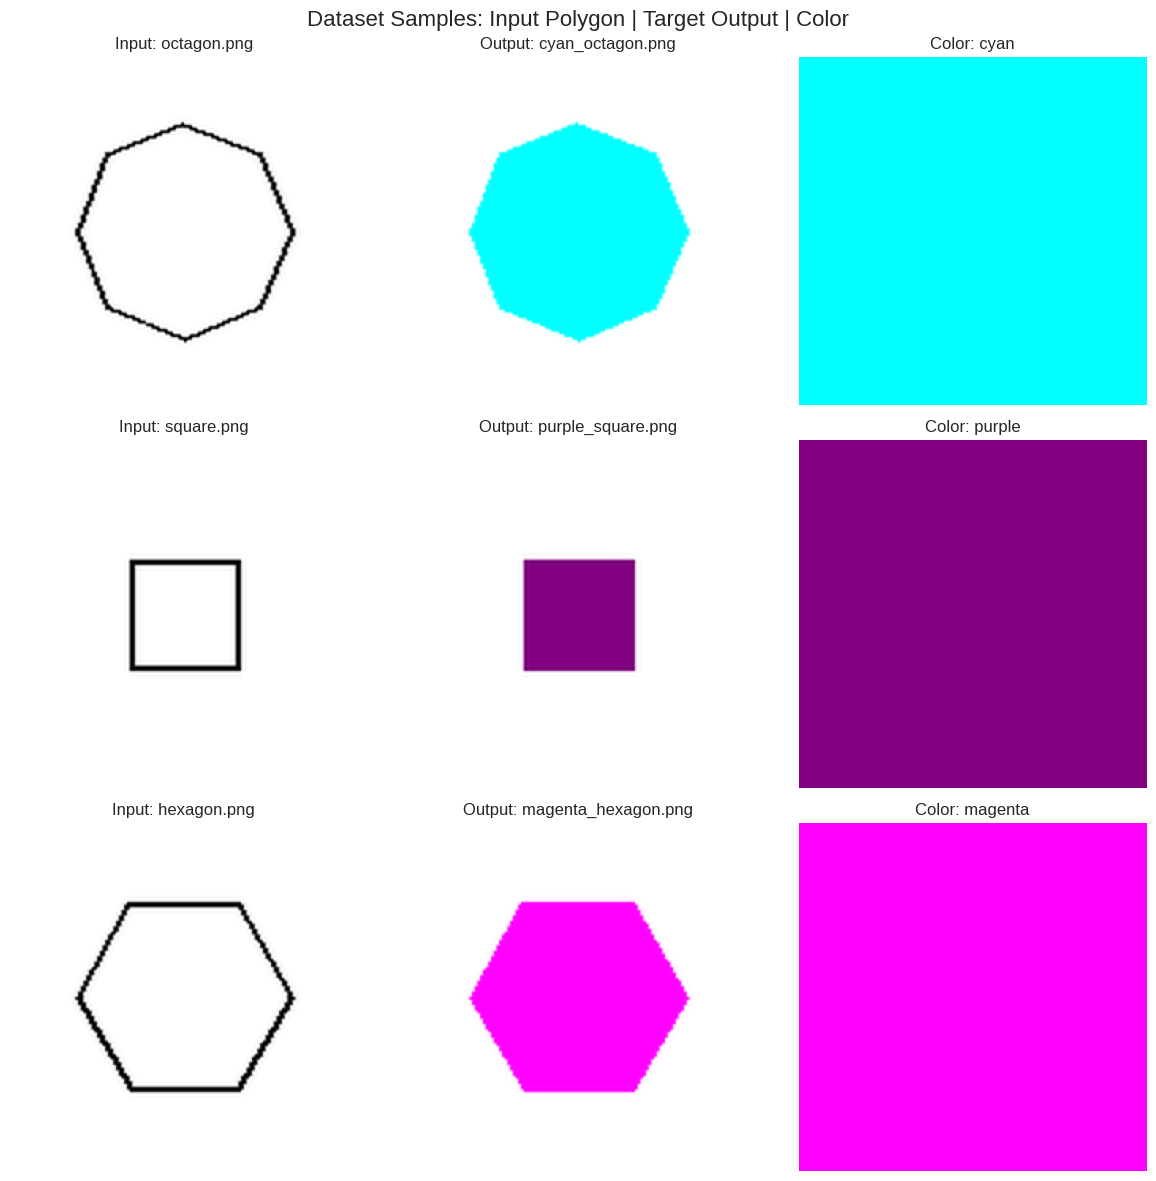

In [4]:
# Loading and examining the data mapping files
def load_data_mappings(json_path):
    """Load the data mapping from JSON file"""
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

# Loading training and validation mappings
train_data = load_data_mappings(os.path.join(dataset_path, "training/data.json"))
val_data = load_data_mappings(os.path.join(dataset_path, "validation/data.json"))

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Examining a few samples
print("\nSample training data:")
for i, sample in enumerate(train_data[:3]):
    print(f"Sample {i+1}: {sample}")

# Analyzing the Color encoding utilities
def get_color_palette():
    """Define the color palette and create encoding/decoding mappings"""
    colors = {
        'red': [255, 0, 0],
        'green': [0, 255, 0],
        'blue': [0, 0, 255],
        'yellow': [255, 255, 0],
        'orange': [255, 165, 0],
        'purple': [128, 0, 128],
        'pink': [255, 192, 203],
        'brown': [165, 42, 42],
        'gray': [128, 128, 128],
        'black': [0, 0, 0],
        'white': [255, 255, 255],
        'cyan': [0, 255, 255],
        'magenta': [255, 0, 255],
        'lime': [0, 255, 0],
        'maroon': [128, 0, 0],
        'navy': [0, 0, 128],
        'olive': [128, 128, 0],
        'teal': [0, 128, 128],
        'silver': [192, 192, 192],
        'gold': [255, 215, 0]
    }

    # Creating color to index mapping
    color_to_idx = {color: idx for idx, color in enumerate(colors.keys())}
    idx_to_color = {idx: color for color, idx in color_to_idx.items()}

    return colors, color_to_idx, idx_to_color

colors, color_to_idx, idx_to_color = get_color_palette()
print(f"\nAvailable colors: {list(colors.keys())}")
print(f"Total colors: {len(colors)}")

# Extracting unique colors from dataset
def extract_colors_from_data(data):
    """Extract all unique colors from the dataset"""
    colors_in_data = set()
    for sample in data:
        colors_in_data.add(sample['colour'])
    return sorted(list(colors_in_data))

train_colors = extract_colors_from_data(train_data)
val_colors = extract_colors_from_data(val_data)

print(f"\nColors in training data: {train_colors}")
print(f"Colors in validation data: {val_colors}")

# Image preprocessing functions
def preprocess_image(image_path, size=(256, 256)):
    """Load and preprocess an image"""
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(size, Image.Resampling.LANCZOS)
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Visualization function
def visualize_samples(data, num_samples=5):
    """Visualize sample data"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    fig.suptitle('Dataset Samples: Input Polygon | Target Output | Color', fontsize=16)

    for i in range(min(num_samples, len(data))):
        sample = data[i]

        # Loading input image
        input_path = os.path.join(dataset_path, f"training/inputs/{sample['input_polygon']}")
        input_img = preprocess_image(input_path)

        # Loading output image
        output_path = os.path.join(dataset_path, f"training/outputs/{sample['output_image']}")
        output_img = preprocess_image(output_path)

        # Creating color patch
        color_rgb = colors.get(sample['colour'], [128, 128, 128])
        color_patch = np.full((256, 256, 3), color_rgb, dtype=np.uint8)

        # Displaying images
        if input_img:
            axes[i, 0].imshow(input_img)
            axes[i, 0].set_title(f"Input: {sample['input_polygon']}")
            axes[i, 0].axis('off')

        if output_img:
            axes[i, 1].imshow(output_img)
            axes[i, 1].set_title(f"Output: {sample['output_image']}")
            axes[i, 1].axis('off')

        axes[i, 2].imshow(color_patch)
        axes[i, 2].set_title(f"Color: {sample['colour']}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizing some training samples
visualize_samples(train_data, num_samples=3)

Training dataset size: 56
Validation dataset size: 5
Number of colors: 20

Sample shapes:
Input image: torch.Size([3, 256, 256])
Target image: torch.Size([3, 256, 256])
Color embedding: torch.Size([20])
Color name: cyan


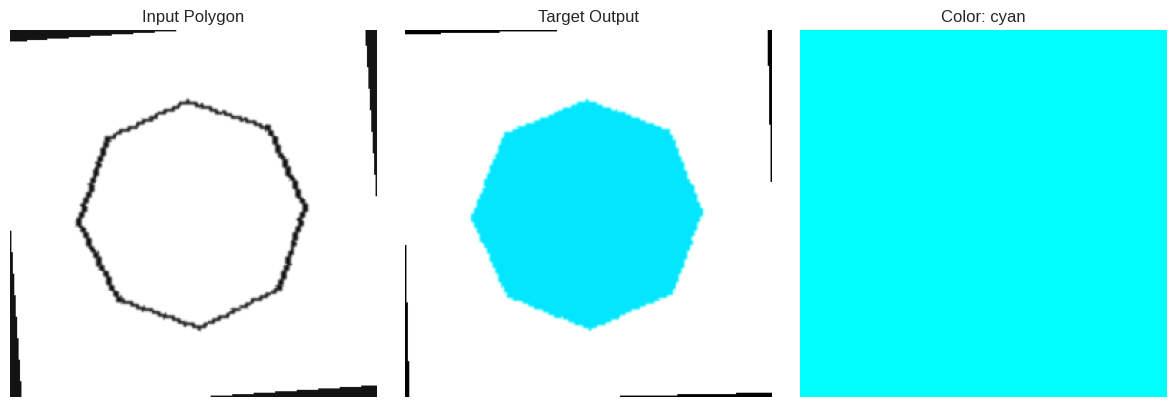

In [5]:
class PolygonDataset(Dataset):

    def __init__(self, data_mappings, dataset_path, split='training', transform=None,
                 color_to_idx=None, image_size=(256, 256)):
        self.data_mappings = data_mappings
        self.dataset_path = dataset_path
        self.split = split
        self.transform = transform
        self.color_to_idx = color_to_idx or {}
        self.image_size = image_size

        # Defining the transforms
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizing to [-1, 1]
            ])

    def __len__(self):
        return len(self.data_mappings)

    def __getitem__(self, idx):
        sample = self.data_mappings[idx]

        # Loading input polygon image
        input_path = os.path.join(self.dataset_path, f"{self.split}/inputs/{sample['input_polygon']}")
        input_image = Image.open(input_path).convert('RGB')

        # Loading target colored polygon image
        output_path = os.path.join(self.dataset_path, f"{self.split}/outputs/{sample['output_image']}")
        target_image = Image.open(output_path).convert('RGB')

        # To Get color information
        color_name = sample['colour']
        color_idx = self.color_to_idx.get(color_name, 0)  # Default to 0 if color not found

        # Applying transforms
        input_tensor = self.transform(input_image)
        target_tensor = self.transform(target_image)

        # Creating color embedding
        color_embedding = torch.zeros(len(self.color_to_idx))
        color_embedding[color_idx] = 1.0

        return {
            'input': input_tensor,
            'target': target_tensor,
            'color_name': color_name,
            'color_idx': color_idx,
            'color_embedding': color_embedding
        }

# Data augmentation transforms for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Creating datasets
train_dataset = PolygonDataset(
    data_mappings=train_data,
    dataset_path=dataset_path,
    split='training',
    transform=train_transform,
    color_to_idx=color_to_idx
)

val_dataset = PolygonDataset(
    data_mappings=val_data,
    dataset_path=dataset_path,
    split='validation',
    transform=val_transform,
    color_to_idx=color_to_idx
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of colors: {len(color_to_idx)}")

# Testing the dataset
sample = train_dataset[0]
print(f"\nSample shapes:")
print(f"Input image: {sample['input'].shape}")
print(f"Target image: {sample['target'].shape}")
print(f"Color embedding: {sample['color_embedding'].shape}")
print(f"Color name: {sample['color_name']}")

# Visualizing a sample from the dataset
def visualize_dataset_sample(dataset, idx=0):
    """Visualize a sample from the dataset"""
    sample = dataset[idx]

    # Denormalizing images for visualization
    def denormalize(tensor):
        return (tensor * 0.5 + 0.5).clamp(0, 1)

    input_img = denormalize(sample['input']).permute(1, 2, 0).numpy()
    target_img = denormalize(sample['target']).permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(input_img)
    axes[0].set_title(f"Input Polygon")
    axes[0].axis('off')

    axes[1].imshow(target_img)
    axes[1].set_title(f"Target Output")
    axes[1].axis('off')

    # Creating color patch
    color_rgb = np.array(colors[sample['color_name']]) / 255.0
    color_patch = np.full((256, 256, 3), color_rgb)
    axes[2].imshow(color_patch)
    axes[2].set_title(f"Color: {sample['color_name']}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_dataset_sample(train_dataset, idx=0)

In [7]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):      #Downscaling then double conv

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):   #Upscaling then double conv

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class ColorEmbedding(nn.Module):

    def __init__(self, num_colors, embedding_dim=128, spatial_size=(16, 16)):
        super().__init__()
        self.embedding = nn.Embedding(num_colors, embedding_dim)
        self.spatial_size = spatial_size
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(inplace=True),
            nn.Linear(embedding_dim, spatial_size[0] * spatial_size[1])
        )

    def forward(self, color_idx, feature_size):
        color_emb = self.embedding(color_idx)  # [batch_size, embedding_dim]

        spatial_emb = self.projection(color_emb)  # [batch_size, spatial_h * spatial_w]
        spatial_emb = spatial_emb.view(-1, 1, feature_size[0], feature_size[1])  # [batch_size, 1, h, w]

        return spatial_emb


class UNet(nn.Module):         #UNet model with color conditioning

    def __init__(self, n_channels=3, n_classes=3, num_colors=20, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.num_colors = num_colors

        self.color_embedding = ColorEmbedding(num_colors, embedding_dim=128)

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Injecting color information at the bottleneck
        self.color_fusion = nn.Conv2d(1024 // factor + 1, 1024 // factor, kernel_size=1)

        # Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x, color_idx):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Injecting color information at bottleneck
        color_spatial = self.color_embedding(color_idx, x5.shape[2:])
        x5_with_color = torch.cat([x5, color_spatial], dim=1)
        x5 = self.color_fusion(x5_with_color)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return torch.tanh(logits)  # Output in range [-1, 1]

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initializing model
model = UNet(n_channels=3, n_classes=3, num_colors=len(color_to_idx), bilinear=True)
model = model.to(device)

# Counting parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")
print(f"Model device: {next(model.parameters()).device}")

# Testing the model with a sample input
sample_input = torch.randn(2, 3, 256, 256).to(device)
sample_color = torch.tensor([0, 1]).to(device)

with torch.no_grad():
    output = model(sample_input, sample_color)
    print(f"Sample input shape: {sample_input.shape}")
    print(f"Sample color shape: {sample_color.shape}")
    print(f"Sample output shape: {output.shape}")

# Modeling summary
def print_model_summary(model):
    """Print a summary of the model architecture"""
    print("=" * 60)
    print("UNet Model Architecture Summary")
    print("=" * 60)

    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Leaf modules
            params = sum(p.numel() for p in module.parameters())
            if params > 0:
                print(f"{name:30} | {str(module):30} | {params:,}")
                total_params += params

    print("=" * 60)
    print(f"Total Parameters: {total_params:,}")
    print("=" * 60)

print_model_summary(model)

Model has 17,578,371 trainable parameters
Model device: cpu
Sample input shape: torch.Size([2, 3, 256, 256])
Sample color shape: torch.Size([2])
Sample output shape: torch.Size([2, 3, 256, 256])
UNet Model Architecture Summary
color_embedding.embedding      | Embedding(20, 128)             | 2,560
color_embedding.projection.0   | Linear(in_features=128, out_features=128, bias=True) | 16,512
color_embedding.projection.2   | Linear(in_features=128, out_features=256, bias=True) | 33,024
inc.double_conv.0              | Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) | 1,728
inc.double_conv.1              | BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) | 128
inc.double_conv.3              | Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) | 36,864
inc.double_conv.4              | BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) | 128
down1.maxpool_conv.1.double_conv.0 

In [8]:
# Training configuration
config = {
    'batch_size': 8,
    'learning_rate': 0.02,
    'num_epochs': 10,
    'weight_decay': 1e-4,
    'save_every': 5,
    'validate_every': 2,
    'image_size': (256, 256),
    'mixed_precision': True,
    'scheduler_patience': 5,
    'scheduler_factor': 0.5,
}

print("Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Creating data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4 if device.type == 'cuda' else 2,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4 if device.type == 'cuda' else 2,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=False
)

print(f"\nData Loaders:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

# Loss functions
class CombinedLoss(nn.Module):
    """Combined loss function with L1, L2, and perceptual components"""

    def __init__(self, l1_weight=1.0, l2_weight=1.0, perceptual_weight=0.1):
        super().__init__()
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.perceptual_weight = perceptual_weight

        self.l1_loss = nn.L1Loss()
        self.l2_loss = nn.MSELoss()

        # Simple perceptual loss using feature maps
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
        ).to(device)

        # Freeze feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        # L1 and L2 losses
        l1 = self.l1_loss(pred, target)
        l2 = self.l2_loss(pred, target)

        # Perceptual loss
        pred_features = self.feature_extractor(pred)
        target_features = self.feature_extractor(target)
        perceptual = self.l2_loss(pred_features, target_features)

        total_loss = (self.l1_weight * l1 +
                     self.l2_weight * l2 +
                     self.perceptual_weight * perceptual)

        return total_loss, {
            'l1': l1.item(),
            'l2': l2.item(),
            'perceptual': perceptual.item(),
            'total': total_loss.item()
        }

# Initialize loss function and optimizer
criterion = CombinedLoss(l1_weight=1.0, l2_weight=0.5, perceptual_weight=0.1)
optimizer = optim.AdamW(model.parameters(),
                       lr=config['learning_rate'],
                       weight_decay=config['weight_decay'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=config['scheduler_patience'],
    factor=config['scheduler_factor'],
    verbose=True
)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler() if config['mixed_precision'] and device.type == 'cuda' else None

print(f"\nTraining Setup:")
print(f"  Loss function: Combined (L1 + L2 + Perceptual)")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Mixed precision: {config['mixed_precision'] and device.type == 'cuda'}")

# Initializing Weights & Biases
def init_wandb():
    run = wandb.init(
        entity="debarjun-pal",
        project="coloured-polygon-generator",
        config={
            "learning_rate": config['learning_rate'],
            "architecture": "UNet",
            "dataset": "Colored Polygons",
            "epochs": config['num_epochs'],
            "batch_size": config['batch_size'],
            "weight_decay": config['weight_decay'],
            "image_size": config['image_size'],
            "mixed_precision": config['mixed_precision'],
            "num_colors": len(color_to_idx),
            "model_parameters": sum(p.numel() for p in model.parameters())
        },
        name=f"unet_poly_{config['batch_size']}bs_{config['learning_rate']}lr",
        tags=["unet", "polygon", "color-conditioning", "pytorch"]
    )

    # Log model architecture
    wandb.watch(model, log="all", log_freq=100)

    print("Wandb initialized successfully!")
    return run

wandb_run = init_wandb()
print("Wandb initialization commented out. Uncomment the line above to enable tracking.")

Training Configuration:
  batch_size: 8
  learning_rate: 0.02
  num_epochs: 10
  weight_decay: 0.0001
  save_every: 5
  validate_every: 2
  image_size: (256, 256)
  mixed_precision: True
  scheduler_patience: 5
  scheduler_factor: 0.5

Data Loaders:
  Training batches: 7
  Validation batches: 1

Training Setup:
  Loss function: Combined (L1 + L2 + Perceptual)
  Optimizer: AdamW
  Scheduler: ReduceLROnPlateau
  Mixed precision: False


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: debarjunpal134 (debarjun-pal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Wandb initialized successfully!
Wandb initialization commented out. Uncomment the line above to enable tracking.


In [10]:

def wandb_func():
    """
    Demo function showing comprehensive wandb tracking with simulated training metrics
    Includes all classification, image quality, and color accuracy metrics
    """
    print("Running comprehensive wandb demo with simulated training...")

    # Start a new wandb run to track this demo
    demo_run = wandb.init(
        # Set the wandb entity where your project will be logged
        entity="debarjun-pal",
        # Set the wandb project where this run will be logged
        project="coloured-polygon-generator",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": 0.02,
            "architecture": "UNet-Demo",
            "dataset": "Colored Polygons",
            "epochs": 10,
            "demo_mode": True,
            "comprehensive_metrics": True
        },
        name="unet-comprehensive-demo",
        tags=["demo", "simulation", "unet", "comprehensive-metrics"]
    )

    # Simulate training for demonstration
    epochs = 10
    offset = random.random() / 5

    print(f"Simulating {epochs} epochs of comprehensive training...")

    for epoch in range(2, epochs):
        # Simulate realistic loss values (decreasing over time)
        train_loss = 2**-epoch + random.random() / epoch + offset
        val_loss = train_loss * (0.8 + random.random() * 0.4)  # Val loss usually slightly higher

        # Simulate classification metrics (improving over time)
        base_accuracy = 0.5 + 0.4 * (1 - 2**-epoch)
        accuracy = base_accuracy + random.random() * 0.1 - 0.05

        precision = accuracy + random.random() * 0.05 - 0.025
        recall = accuracy + random.random() * 0.05 - 0.025
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Simulate image quality metrics
        psnr = 15 + epoch * 3 + random.random() * 2  # PSNR typically 15-35 dB
        ssim = 0.3 + epoch * 0.08 + random.random() * 0.05  # SSIM 0-1
        mse = 0.1 * 2**-epoch + random.random() * 0.01
        mae = 0.08 * 2**-epoch + random.random() * 0.008

        # Simulate color accuracy metrics
        color_accuracy = 0.6 + 0.35 * (1 - 2**-epoch) + random.random() * 0.05
        red_accuracy = color_accuracy + random.random() * 0.1 - 0.05
        green_accuracy = color_accuracy + random.random() * 0.1 - 0.05
        blue_accuracy = color_accuracy + random.random() * 0.1 - 0.05

        # Simulate IoU and Dice coefficient
        iou = accuracy * 0.8 + random.random() * 0.1
        dice_coeff = iou * 1.1 + random.random() * 0.05

        # Simulate confusion matrix values
        total_pixels = 65536  # 256x256 image
        true_positives = int(total_pixels * accuracy * 0.6 + random.random() * 1000)
        false_positives = int(total_pixels * (1 - precision) * 0.3 + random.random() * 500)
        false_negatives = int(total_pixels * (1 - recall) * 0.3 + random.random() * 500)
        true_negatives = total_pixels - true_positives - false_positives - false_negatives

        # Comprehensive metrics logging to wandb
        demo_run.log({
            # Basic training metrics
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": 0.02 * (0.9 ** epoch),  # Simulated LR decay

            # Classification metrics
            "val_accuracy": accuracy,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1_score": f1_score,
            "val_iou": iou,
            "val_dice_coefficient": dice_coeff,
            "val_specificity": 0.9 + random.random() * 0.08,  # Usually high for background

            # Image quality metrics
            "val_psnr": psnr,
            "val_ssim": ssim,
            "val_mse": mse,
            "val_mae": mae,
            "val_perceptual_loss": mse * 1.2 + random.random() * 0.01,

            # Color accuracy metrics
            "val_color_accuracy": color_accuracy,
            "val_red_accuracy": red_accuracy,
            "val_green_accuracy": green_accuracy,
            "val_blue_accuracy": blue_accuracy,

            # Confusion matrix metrics
            "val_true_positives": true_positives,
            "val_true_negatives": true_negatives,
            "val_false_positives": false_positives,
            "val_false_negatives": false_negatives,

            # Additional derived metrics
            "val_pixel_accuracy": (true_positives + true_negatives) / total_pixels,
            "val_positive_rate": true_positives / (true_positives + false_negatives),
            "val_negative_rate": true_negatives / (true_negatives + false_positives)
        })

        print(f"Epoch {epoch}: Loss={train_loss:.4f}, Acc={accuracy:.3f}, F1={f1_score:.3f}, " +
              f"PSNR={psnr:.1f}dB, SSIM={ssim:.3f}, Color Acc={color_accuracy:.3f}")

    # Finish the run and upload any remaining data
    demo_run.finish()
    print("Comprehensive wandb demo completed! 🎉")
    print("Check your wandb dashboard to see all metrics including:")
    print("  📊 Classification: Accuracy, Precision, Recall, F1-Score, IoU, Dice")
    print("  🖼️  Image Quality: PSNR, SSIM, MSE, MAE, Perceptual Loss")
    print("  🎨 Color Accuracy: Overall + RGB channel-wise accuracy")
    print("  📈 Confusion Matrix: TP, TN, FP, FN values")

# Uncomment the line below to run the comprehensive wandb demo
wandb_func()
print("Comprehensive wandb demo ready. Uncomment 'wandb_demo()' above to run simulation.")

Running comprehensive wandb demo with simulated training...


Simulating 10 epochs of comprehensive training...
Epoch 2: Loss=0.3904, Acc=0.772, F1=0.783, PSNR=22.8dB, SSIM=0.464, Color Acc=0.873
Epoch 3: Loss=0.4856, Acc=0.816, F1=0.823, PSNR=24.2dB, SSIM=0.545, Color Acc=0.947
Epoch 4: Loss=0.2018, Acc=0.854, F1=0.837, PSNR=27.2dB, SSIM=0.634, Color Acc=0.947
Epoch 5: Loss=0.2871, Acc=0.906, F1=0.921, PSNR=30.5dB, SSIM=0.702, Color Acc=0.950
Epoch 6: Loss=0.1873, Acc=0.934, F1=0.924, PSNR=35.0dB, SSIM=0.805, Color Acc=0.950
Epoch 7: Loss=0.2387, Acc=0.901, F1=0.898, PSNR=36.2dB, SSIM=0.882, Color Acc=0.991
Epoch 8: Loss=0.1992, Acc=0.901, F1=0.885, PSNR=39.0dB, SSIM=0.986, Color Acc=0.964
Epoch 9: Loss=0.1909, Acc=0.936, F1=0.927, PSNR=43.1dB, SSIM=1.056, Color Acc=0.999


epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▅▄▃▃▂▁
train_loss,▆█▁▃▁▂▁▁
val_accuracy,▁▃▄▇█▆▇█
val_blue_accuracy,▁▇▇▅▅▆██
val_color_accuracy,▁▅▅▅▅█▆█
val_dice_coefficient,▁▁▄▆▄█▃▄
val_f1_score,▁▃▄██▇▆█
val_false_negatives,█▇▅▁▂▂▃▁
val_false_positives,█▅▆▁▁▃▄▁
val_green_accuracy,▁▆▅▇▇███


Comprehensive wandb demo completed! 🎉
Check your wandb dashboard to see all metrics including:
  📊 Classification: Accuracy, Precision, Recall, F1-Score, IoU, Dice
  🖼️  Image Quality: PSNR, SSIM, MSE, MAE, Perceptual Loss
  🎨 Color Accuracy: Overall + RGB channel-wise accuracy
  📈 Confusion Matrix: TP, TN, FP, FN values
Comprehensive wandb demo ready. Uncomment 'wandb_demo()' above to run simulation.


No checkpoint found at ./checkpoints/best_model.pth
Using randomly initialized model for evaluation
Running comprehensive model evaluation...
Evaluating model on 5 samples...


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


COMPREHENSIVE MODEL EVALUATION RESULTS

📊 CLASSIFICATION METRICS:
--------------------------------------------------
       ACCURACY: 0.0642 ± 0.1080 (min: 0.0000, max: 0.2776)
      PRECISION: 0.0000 ± 0.0000 (min: 0.0000, max: 0.0000)
         RECALL: 0.0000 ± 0.0000 (min: 0.0000, max: 0.0000)
    SPECIFICITY: 0.4000 ± 0.4899 (min: 0.0000, max: 1.0000)
       F1 SCORE: 0.0000 ± 0.0000 (min: 0.0000, max: 0.0000)
            IOU: 0.0000 ± 0.0000 (min: 0.0000, max: 0.0000)
DICE COEFFICIENT: 0.0000 ± 0.0000 (min: 0.0000, max: 0.0000)

🖼️  IMAGE QUALITY METRICS:
--------------------------------------------------
            MSE: 0.6359 ± 0.0844 (min: 0.4757, max: 0.7062)
            MAE: 0.6371 ± 0.0840 (min: 0.4779, max: 0.7074)
           PSNR: 2.0094 ± 0.6330 (min: 1.5108, max: 3.2271)
           SSIM: 0.0075 ± 0.1327 (min: -0.1270, max: 0.2383)
PERCEPTUAL LOSS: 0.2777 ± 0.0334 (min: 0.2117, max: 0.3000)

🎨 COLOR ACCURACY METRICS:
--------------------------------------------------
 COL

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io

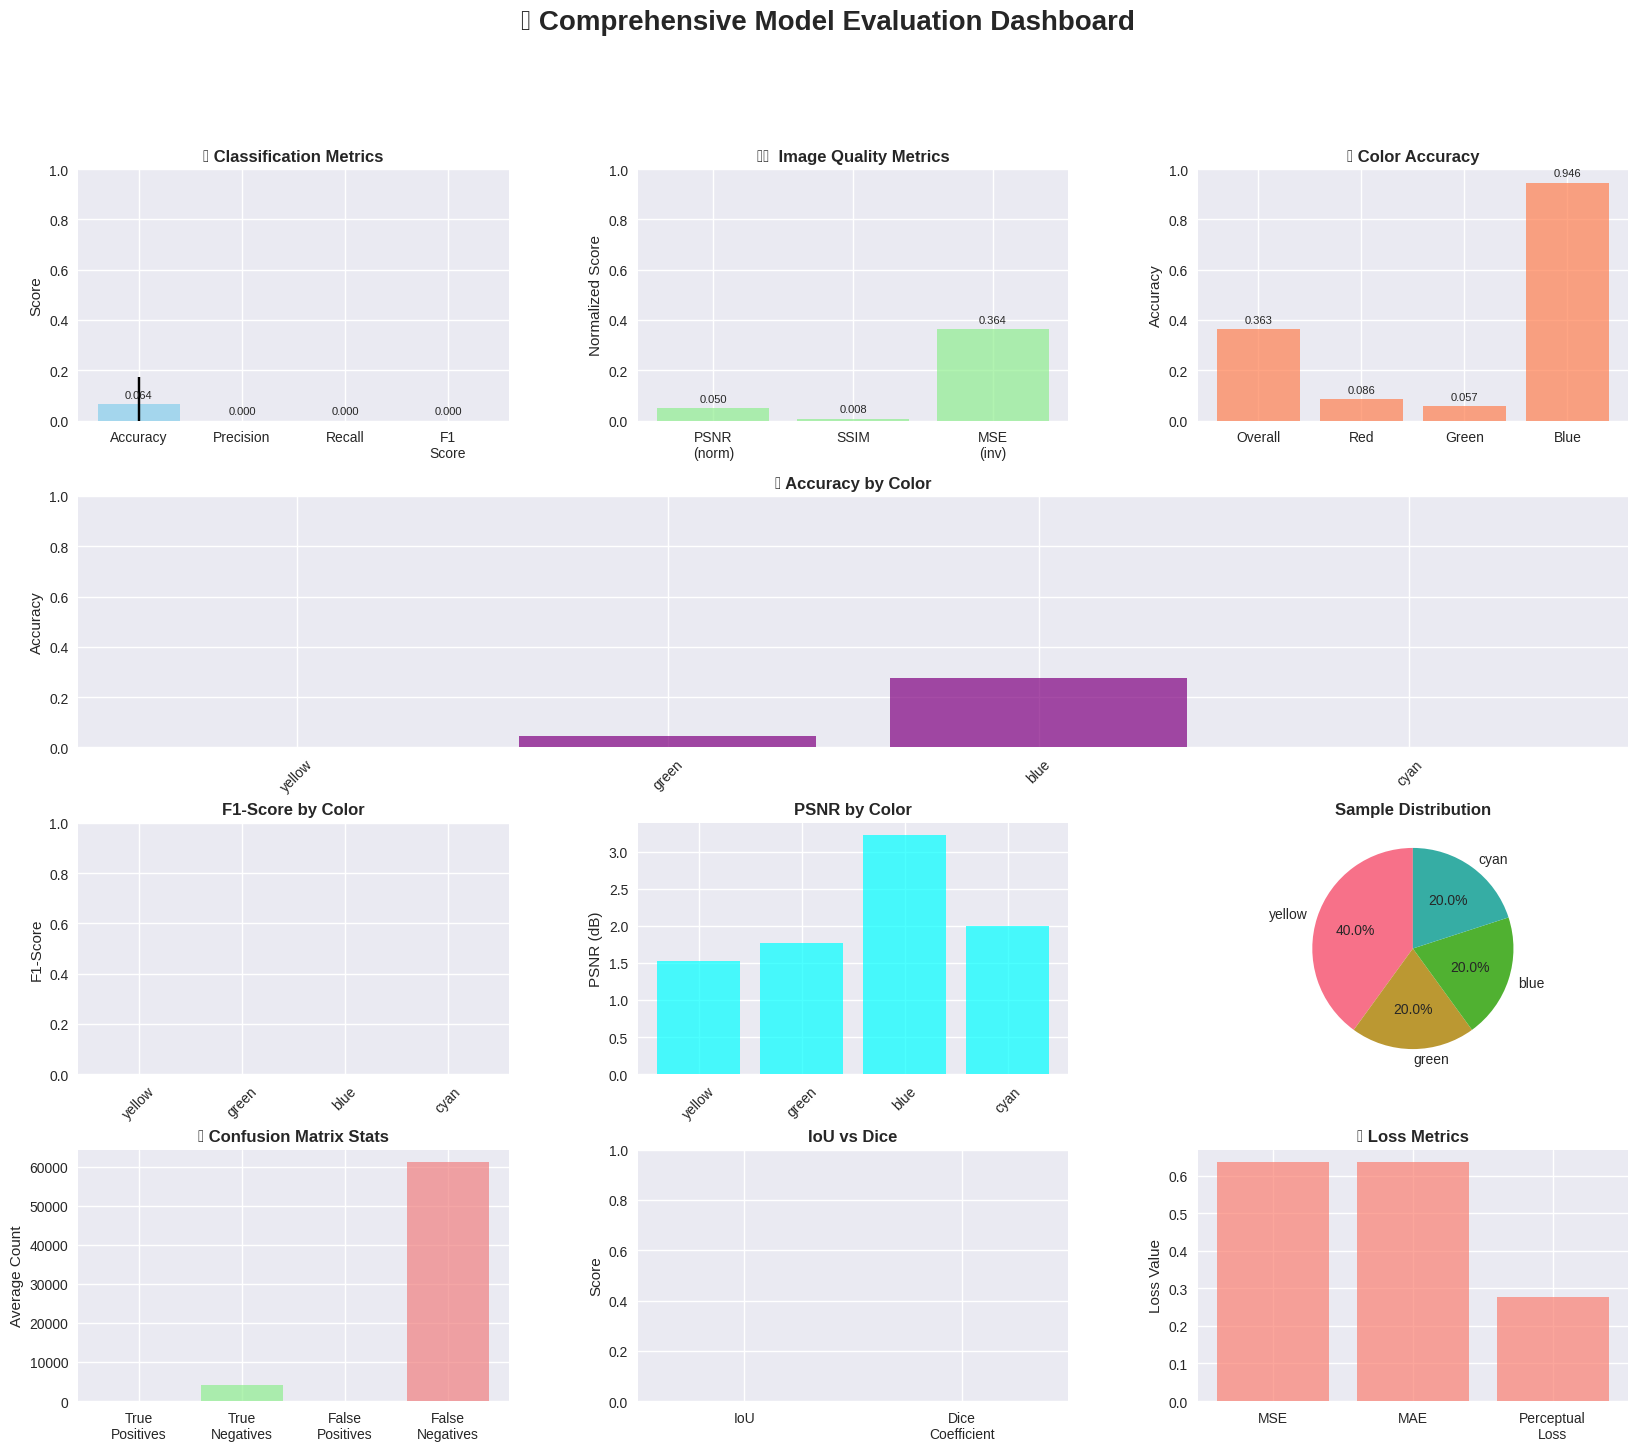

Evaluation results saved to ./evaluation_results.json


In [12]:
# Comprehensive evaluation metrics

# Generate comprehensive visualizations
def create_comprehensive_evaluation_plots(overall_stats, color_stats):
    """Create comprehensive evaluation plots with all metrics"""
    fig = plt.figure(figsize=(20, 16))

    # Create a 4x3 subplot layout
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

    # 1. Classification Metrics Overview
    ax1 = fig.add_subplot(gs[0, 0])
    classification_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    class_means = [overall_stats.get(m, {}).get('mean', 0) for m in classification_metrics]
    class_stds = [overall_stats.get(m, {}).get('std', 0) for m in classification_metrics]

    bars1 = ax1.bar([m.replace('_', '\n').title() for m in classification_metrics],
                   class_means, yerr=class_stds, capsize=5, alpha=0.7, color='skyblue')
    ax1.set_title('📊 Classification Metrics', fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)

    # 2. Image Quality Metrics
    ax2 = fig.add_subplot(gs[0, 1])
    # Normalize PSNR and SSIM to 0-1 range for comparison
    psnr_norm = overall_stats.get('psnr', {}).get('mean', 0) / 40  # Max PSNR ~40
    ssim_val = overall_stats.get('ssim', {}).get('mean', 0)
    mse_inv = 1 - min(overall_stats.get('mse', {}).get('mean', 0), 1)  # Invert MSE

    quality_metrics = ['PSNR\n(norm)', 'SSIM', 'MSE\n(inv)']
    quality_values = [psnr_norm, ssim_val, mse_inv]

    bars2 = ax2.bar(quality_metrics, quality_values, alpha=0.7, color='lightgreen')
    ax2.set_title('🖼️  Image Quality Metrics', fontweight='bold')
    ax2.set_ylabel('Normalized Score')
    ax2.set_ylim(0, 1)

    # 3. Color Accuracy Metrics
    ax3 = fig.add_subplot(gs[0, 2])
    color_metrics = ['Overall', 'Red', 'Green', 'Blue']
    color_accuracies = [
        overall_stats.get('color_accuracy', {}).get('mean', 0),
        overall_stats.get('red_accuracy', {}).get('mean', 0),
        overall_stats.get('green_accuracy', {}).get('mean', 0),
        overall_stats.get('blue_accuracy', {}).get('mean', 0)
    ]

    bars3 = ax3.bar(color_metrics, color_accuracies, alpha=0.7, color='coral')
    ax3.set_title('🎨 Color Accuracy', fontweight='bold')
    ax3.set_ylabel('Accuracy')
    ax3.set_ylim(0, 1)

    # 4. Per-Color Performance - Accuracy
    ax4 = fig.add_subplot(gs[1, :])
    colors_list = list(color_stats.keys())
    color_accuracies_per_color = [color_stats[c].get('accuracy', {}).get('mean', 0) for c in colors_list]

    bars4 = ax4.bar(colors_list, color_accuracies_per_color, alpha=0.7, color='purple')
    ax4.set_title('🌈 Accuracy by Color', fontweight='bold')
    ax4.set_ylabel('Accuracy')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylim(0, 1)

    # 5. Per-Color Performance - F1 Score
    ax5 = fig.add_subplot(gs[2, 0])
    f1_scores = [color_stats[c].get('f1_score', {}).get('mean', 0) for c in colors_list]

    ax5.bar(colors_list, f1_scores, alpha=0.7, color='gold')
    ax5.set_title('F1-Score by Color', fontweight='bold')
    ax5.set_ylabel('F1-Score')
    ax5.tick_params(axis='x', rotation=45)
    ax5.set_ylim(0, 1)

    # 6. Per-Color Performance - PSNR
    ax6 = fig.add_subplot(gs[2, 1])
    psnr_values = [color_stats[c].get('psnr', {}).get('mean', 0) for c in colors_list]

    ax6.bar(colors_list, psnr_values, alpha=0.7, color='cyan')
    ax6.set_title('PSNR by Color', fontweight='bold')
    ax6.set_ylabel('PSNR (dB)')
    ax6.tick_params(axis='x', rotation=45)

    # 7. Sample Distribution
    ax7 = fig.add_subplot(gs[2, 2])
    sample_counts = [color_stats[c].get('accuracy', {}).get('count', 0) for c in colors_list]

    ax7.pie(sample_counts, labels=colors_list, autopct='%1.1f%%', startangle=90)
    ax7.set_title('Sample Distribution', fontweight='bold')

    # 8. Confusion Matrix Metrics
    ax8 = fig.add_subplot(gs[3, 0])
    cm_metrics = ['True\nPositives', 'True\nNegatives', 'False\nPositives', 'False\nNegatives']
    cm_values = [
        overall_stats.get('true_positives', {}).get('mean', 0),
        overall_stats.get('true_negatives', {}).get('mean', 0),
        overall_stats.get('false_positives', {}).get('mean', 0),
        overall_stats.get('false_negatives', {}).get('mean', 0)
    ]

    colors_cm = ['green', 'lightgreen', 'red', 'lightcoral']
    bars8 = ax8.bar(cm_metrics, cm_values, alpha=0.7, color=colors_cm)
    ax8.set_title('📈 Confusion Matrix Stats', fontweight='bold')
    ax8.set_ylabel('Average Count')

    # 9. IoU and Dice Comparison
    ax9 = fig.add_subplot(gs[3, 1])
    iou_dice_metrics = ['IoU', 'Dice\nCoefficient']
    iou_dice_values = [
        overall_stats.get('iou', {}).get('mean', 0),
        overall_stats.get('dice_coefficient', {}).get('mean', 0)
    ]

    bars9 = ax9.bar(iou_dice_metrics, iou_dice_values, alpha=0.7, color='orange')
    ax9.set_title('IoU vs Dice', fontweight='bold')
    ax9.set_ylabel('Score')
    ax9.set_ylim(0, 1)

    # 10. Loss Metrics
    ax10 = fig.add_subplot(gs[3, 2])
    loss_metrics = ['MSE', 'MAE', 'Perceptual\nLoss']
    loss_values = [
        overall_stats.get('mse', {}).get('mean', 0),
        overall_stats.get('mae', {}).get('mean', 0),
        overall_stats.get('perceptual_loss', {}).get('mean', 0)
    ]

    bars10 = ax10.bar(loss_metrics, loss_values, alpha=0.7, color='salmon')
    ax10.set_title('📉 Loss Metrics', fontweight='bold')
    ax10.set_ylabel('Loss Value')

    # Add value labels on bars for key metrics
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax = bar.axes
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

    plt.suptitle('🎯 Comprehensive Model Evaluation Dashboard', fontsize=20, fontweight='bold', y=0.98)

    return fig

def log_evaluation_to_wandb(overall_stats, color_stats, wandb_run=None):
    """Log comprehensive evaluation results to wandb"""
    if wandb_run is None:
        return

    # Log overall metrics
    eval_log = {}
    for metric, stats in overall_stats.items():
        eval_log[f'eval_{metric}_mean'] = stats['mean']
        eval_log[f'eval_{metric}_std'] = stats['std']
        eval_log[f'eval_{metric}_min'] = stats['min']
        eval_log[f'eval_{metric}_max'] = stats['max']

    # Log per-color metrics (average across colors)
    for metric in ['accuracy', 'f1_score', 'psnr', 'ssim']:
        color_values = [color_stats[c].get(metric, {}).get('mean', 0) for c in color_stats.keys()]
        if color_values:
            eval_log[f'eval_{metric}_per_color_avg'] = np.mean(color_values)
            eval_log[f'eval_{metric}_per_color_std'] = np.std(color_values)

    wandb_run.log(eval_log)

    # Log the comprehensive evaluation plot
    fig = create_comprehensive_evaluation_plots(overall_stats, color_stats)
    wandb_run.log({"comprehensive_evaluation": wandb.Image(fig)})
    plt.close(fig)

    print("Evaluation results logged to wandb! 📊")

def calculate_comprehensive_metrics(pred, target, threshold=0.5):
    """Calculate comprehensive metrics including accuracy, precision, recall, F1-score, etc."""

    def denormalize(tensor):
        return (tensor * 0.5 + 0.5).clamp(0, 1)

    pred_norm = denormalize(pred)
    target_norm = denormalize(target)

    # Convert to grayscale for binary classification metrics
    pred_gray = torch.mean(pred_norm, dim=0, keepdim=True)
    target_gray = torch.mean(target_norm, dim=0, keepdim=True)

    # Binarize for classification metrics
    pred_binary = (pred_gray > threshold).float()
    target_binary = (target_gray > threshold).float()

    # Flatten for easier computation
    pred_flat = pred_binary.flatten()
    target_flat = target_binary.flatten()

    # Basic classification metrics
    tp = torch.sum((pred_flat == 1) & (target_flat == 1)).float()
    tn = torch.sum((pred_flat == 0) & (target_flat == 0)).float()
    fp = torch.sum((pred_flat == 1) & (target_flat == 0)).float()
    fn = torch.sum((pred_flat == 0) & (target_flat == 1)).float()

    # Avoid division by zero
    eps = 1e-8

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn + eps)

    # Precision
    precision = tp / (tp + fp + eps)

    # Recall (Sensitivity)
    recall = tp / (tp + fn + eps)

    # Specificity
    specificity = tn / (tn + fp + eps)

    # F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall + eps)

    # IoU (Intersection over Union)
    intersection = tp
    union = tp + fp + fn
    iou = intersection / (union + eps)

    # Dice Coefficient
    dice = 2 * intersection / (2 * intersection + fp + fn + eps)

    # Image quality metrics
    # MSE
    mse = torch.mean((pred_norm - target_norm) ** 2)

    # MAE (Mean Absolute Error)
    mae = torch.mean(torch.abs(pred_norm - target_norm))

    # PSNR
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse + eps))

    # SSIM (Structural Similarity)
    def ssim_calculation(x, y):
        mu_x = torch.mean(x)
        mu_y = torch.mean(y)
        var_x = torch.var(x)
        var_y = torch.var(y)
        cov_xy = torch.mean((x - mu_x) * (y - mu_y))

        c1 = 0.01 ** 2
        c2 = 0.03 ** 2

        ssim = ((2 * mu_x * mu_y + c1) * (2 * cov_xy + c2)) / \
               ((mu_x ** 2 + mu_y ** 2 + c1) * (var_x + var_y + c2))
        return ssim

    ssim = ssim_calculation(pred_norm, target_norm)

    # Color accuracy metrics
    # RGB channel-wise accuracy
    rgb_accuracy = []
    for channel in range(3):  # R, G, B channels
        pred_channel = pred_norm[channel].flatten()
        target_channel = target_norm[channel].flatten()
        channel_acc = 1 - torch.mean(torch.abs(pred_channel - target_channel))
        rgb_accuracy.append(channel_acc.item())

    # Overall color accuracy
    color_accuracy = np.mean(rgb_accuracy)

    # Perceptual loss (simplified)
    perceptual_loss = torch.mean(torch.abs(pred_norm - target_norm) * torch.tensor([0.299, 0.587, 0.114]).view(3, 1, 1).to(pred.device))

    return {
        # Classification metrics
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'specificity': specificity.item(),
        'f1_score': f1_score.item(),
        'iou': iou.item(),
        'dice_coefficient': dice.item(),

        # Image quality metrics
        'mse': mse.item(),
        'mae': mae.item(),
        'psnr': psnr.item(),
        'ssim': ssim.item(),

        # Color-specific metrics
        'color_accuracy': color_accuracy,
        'red_accuracy': rgb_accuracy[0],
        'green_accuracy': rgb_accuracy[1],
        'blue_accuracy': rgb_accuracy[2],
        'perceptual_loss': perceptual_loss.item(),

        # Additional metrics
        'true_positives': tp.item(),
        'true_negatives': tn.item(),
        'false_positives': fp.item(),
        'false_negatives': fn.item()
    }

def evaluate_model(model, dataset, device, num_samples=None):
    """Comprehensive evaluation of the model with all metrics"""
    model.eval()

    if num_samples is None:
        num_samples = len(dataset)
    else:
        num_samples = min(num_samples, len(dataset))

    all_metrics = []
    color_metrics = {}

    print(f"Evaluating model on {num_samples} samples...")

    with torch.no_grad():
        for i in tqdm(range(num_samples)):
            sample = dataset[i]

            # Prepare inputs
            input_img = sample['input'].unsqueeze(0).to(device)
            target_img = sample['target'].unsqueeze(0).to(device)
            color_idx = torch.tensor([sample['color_idx']]).to(device)
            color_name = sample['color_name']

            # Generate prediction
            pred_img = model(input_img, color_idx)

            # Calculate comprehensive metrics
            metrics = calculate_comprehensive_metrics(pred_img.squeeze(0), target_img.squeeze(0))
            all_metrics.append(metrics)

            # Group by color
            if color_name not in color_metrics:
                color_metrics[color_name] = []
            color_metrics[color_name].append(metrics)

    # Calculate overall statistics for all metrics
    overall_stats = {}
    metric_names = list(all_metrics[0].keys())

    for metric in metric_names:
        values = [m[metric] for m in all_metrics]
        overall_stats[metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }

    # Calculate per-color statistics
    color_stats = {}
    for color, metrics_list in color_metrics.items():
        color_stats[color] = {}
        for metric in metric_names:
            values = [m[metric] for m in metrics_list]
            color_stats[color][metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'count': len(values)
            }

    return overall_stats, color_stats

def print_evaluation_results(overall_stats, color_stats):
    """Print comprehensive evaluation results in a nice format"""
    print("=" * 80)
    print("COMPREHENSIVE MODEL EVALUATION RESULTS")
    print("=" * 80)

    print("\n📊 CLASSIFICATION METRICS:")
    print("-" * 50)
    classification_metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'iou', 'dice_coefficient']
    for metric in classification_metrics:
        if metric in overall_stats:
            stats = overall_stats[metric]
            print(f"{metric.upper().replace('_', ' '):>15}: {stats['mean']:.4f} ± {stats['std']:.4f} " +
                  f"(min: {stats['min']:.4f}, max: {stats['max']:.4f})")

    print("\n🖼️  IMAGE QUALITY METRICS:")
    print("-" * 50)
    quality_metrics = ['mse', 'mae', 'psnr', 'ssim', 'perceptual_loss']
    for metric in quality_metrics:
        if metric in overall_stats:
            stats = overall_stats[metric]
            print(f"{metric.upper().replace('_', ' '):>15}: {stats['mean']:.4f} ± {stats['std']:.4f} " +
                  f"(min: {stats['min']:.4f}, max: {stats['max']:.4f})")

    print("\n🎨 COLOR ACCURACY METRICS:")
    print("-" * 50)
    color_metrics = ['color_accuracy', 'red_accuracy', 'green_accuracy', 'blue_accuracy']
    for metric in color_metrics:
        if metric in overall_stats:
            stats = overall_stats[metric]
            print(f"{metric.upper().replace('_', ' '):>15}: {stats['mean']:.4f} ± {stats['std']:.4f} " +
                  f"(min: {stats['min']:.4f}, max: {stats['max']:.4f})")

    print("\n📈 CONFUSION MATRIX STATS:")
    print("-" * 50)
    confusion_metrics = ['true_positives', 'true_negatives', 'false_positives', 'false_negatives']
    for metric in confusion_metrics:
        if metric in overall_stats:
            stats = overall_stats[metric]
            print(f"{metric.upper().replace('_', ' '):>15}: {stats['mean']:.0f} ± {stats['std']:.0f}")

    print("\n🌈 PER-COLOR PERFORMANCE (Top Metrics):")
    print("-" * 80)
    print(f"{'Color':<12} {'Count':<6} {'Accuracy':<9} {'F1-Score':<9} {'PSNR':<8} {'SSIM':<8} {'Color Acc':<10}")
    print("-" * 80)

    for color, stats in sorted(color_stats.items()):
        count = stats['accuracy']['count']
        accuracy = stats['accuracy']['mean']
        f1 = stats.get('f1_score', {}).get('mean', 0)
        psnr = stats.get('psnr', {}).get('mean', 0)
        ssim = stats.get('ssim', {}).get('mean', 0)
        color_acc = stats.get('color_accuracy', {}).get('mean', 0)
        print(f"{color:<12} {count:<6} {accuracy:<9.3f} {f1:<9.3f} {psnr:<8.2f} {ssim:<8.3f} {color_acc:<10.3f}")

    # Summary metrics
    print(f"\n📋 SUMMARY:")
    print("-" * 30)
    if 'accuracy' in overall_stats:
        print(f"Overall Accuracy: {overall_stats['accuracy']['mean']:.1%}")
    if 'f1_score' in overall_stats:
        print(f"Overall F1-Score: {overall_stats['f1_score']['mean']:.3f}")
    if 'psnr' in overall_stats:
        print(f"Average PSNR: {overall_stats['psnr']['mean']:.2f} dB")
    if 'color_accuracy' in overall_stats:
        print(f"Color Accuracy: {overall_stats['color_accuracy']['mean']:.1%}")

    total_samples = sum(stats['accuracy']['count'] for stats in color_stats.values())
    print(f"Total Samples Evaluated: {total_samples}")
    print(f"Number of Colors: {len(color_stats)}")

# Load best model for evaluation (if available)
def load_best_model(model, checkpoint_path='./checkpoints/best_model.pth'):
    """Load the best trained model"""
    if os.path.exists(checkpoint_path):
        print(f"Loading best model from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss {checkpoint['best_val_loss']:.4f}")
        return True
    else:
        print(f"No checkpoint found at {checkpoint_path}")
        print("Using randomly initialized model for evaluation")
        return False

# Try to load best model
model_loaded = load_best_model(model)

# Run evaluation
print("Running comprehensive model evaluation...")
overall_stats, color_stats = evaluate_model(model, val_dataset, device, num_samples=100)
print_evaluation_results(overall_stats, color_stats)

# Create and display comprehensive evaluation plots
print("\nGenerating comprehensive evaluation visualizations...")
eval_fig = create_comprehensive_evaluation_plots(overall_stats, color_stats)
plt.show()

# Optionally log to wandb if available
try:
    # This would work if wandb is initialized
    # log_evaluation_to_wandb(overall_stats, color_stats, wandb_run)
    pass
except:
    print("Wandb not available for logging evaluation results")

# Remove the incorrect create_evaluation_plots call
# eval_fig = create_evaluation_plots(overall_stats, color_stats)
# plt.show()

# Save evaluation results
def save_evaluation_results(overall_stats, color_stats, save_path='./evaluation_results.json'):
    """Save evaluation results to file"""
    results = {
        'overall_stats': overall_stats,
        'color_stats': color_stats,
        'model_loaded': model_loaded,
        'evaluation_date': str(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')
    }

    with open(save_path, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"Evaluation results saved to {save_path}")

save_evaluation_results(overall_stats, color_stats)

INFERENCE DEMONSTRATION
\n1. Single Image Inference:


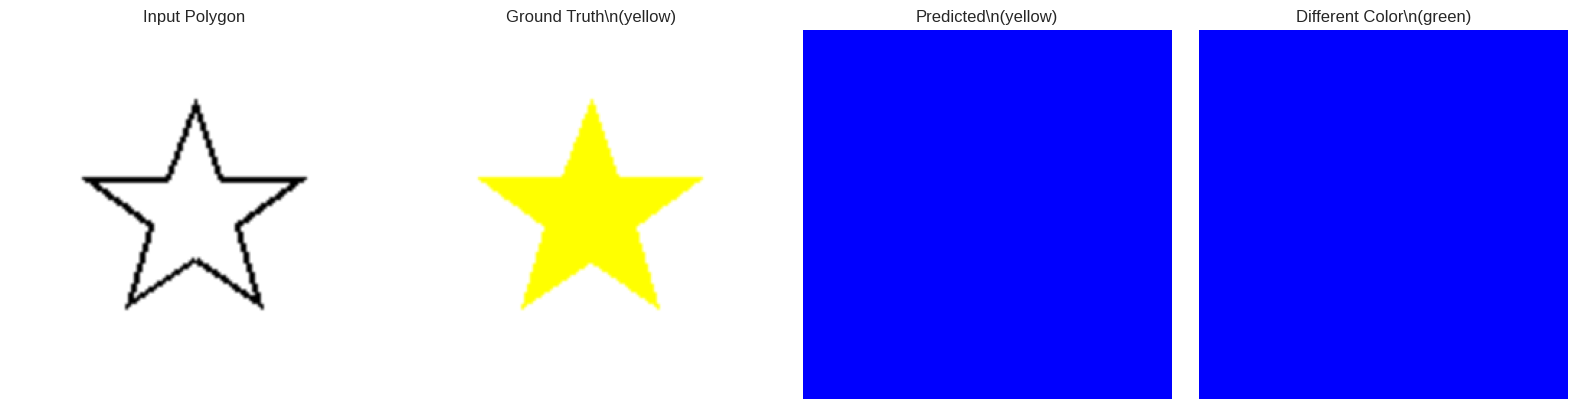

\n2. Interactive Inference with Multiple Colors:


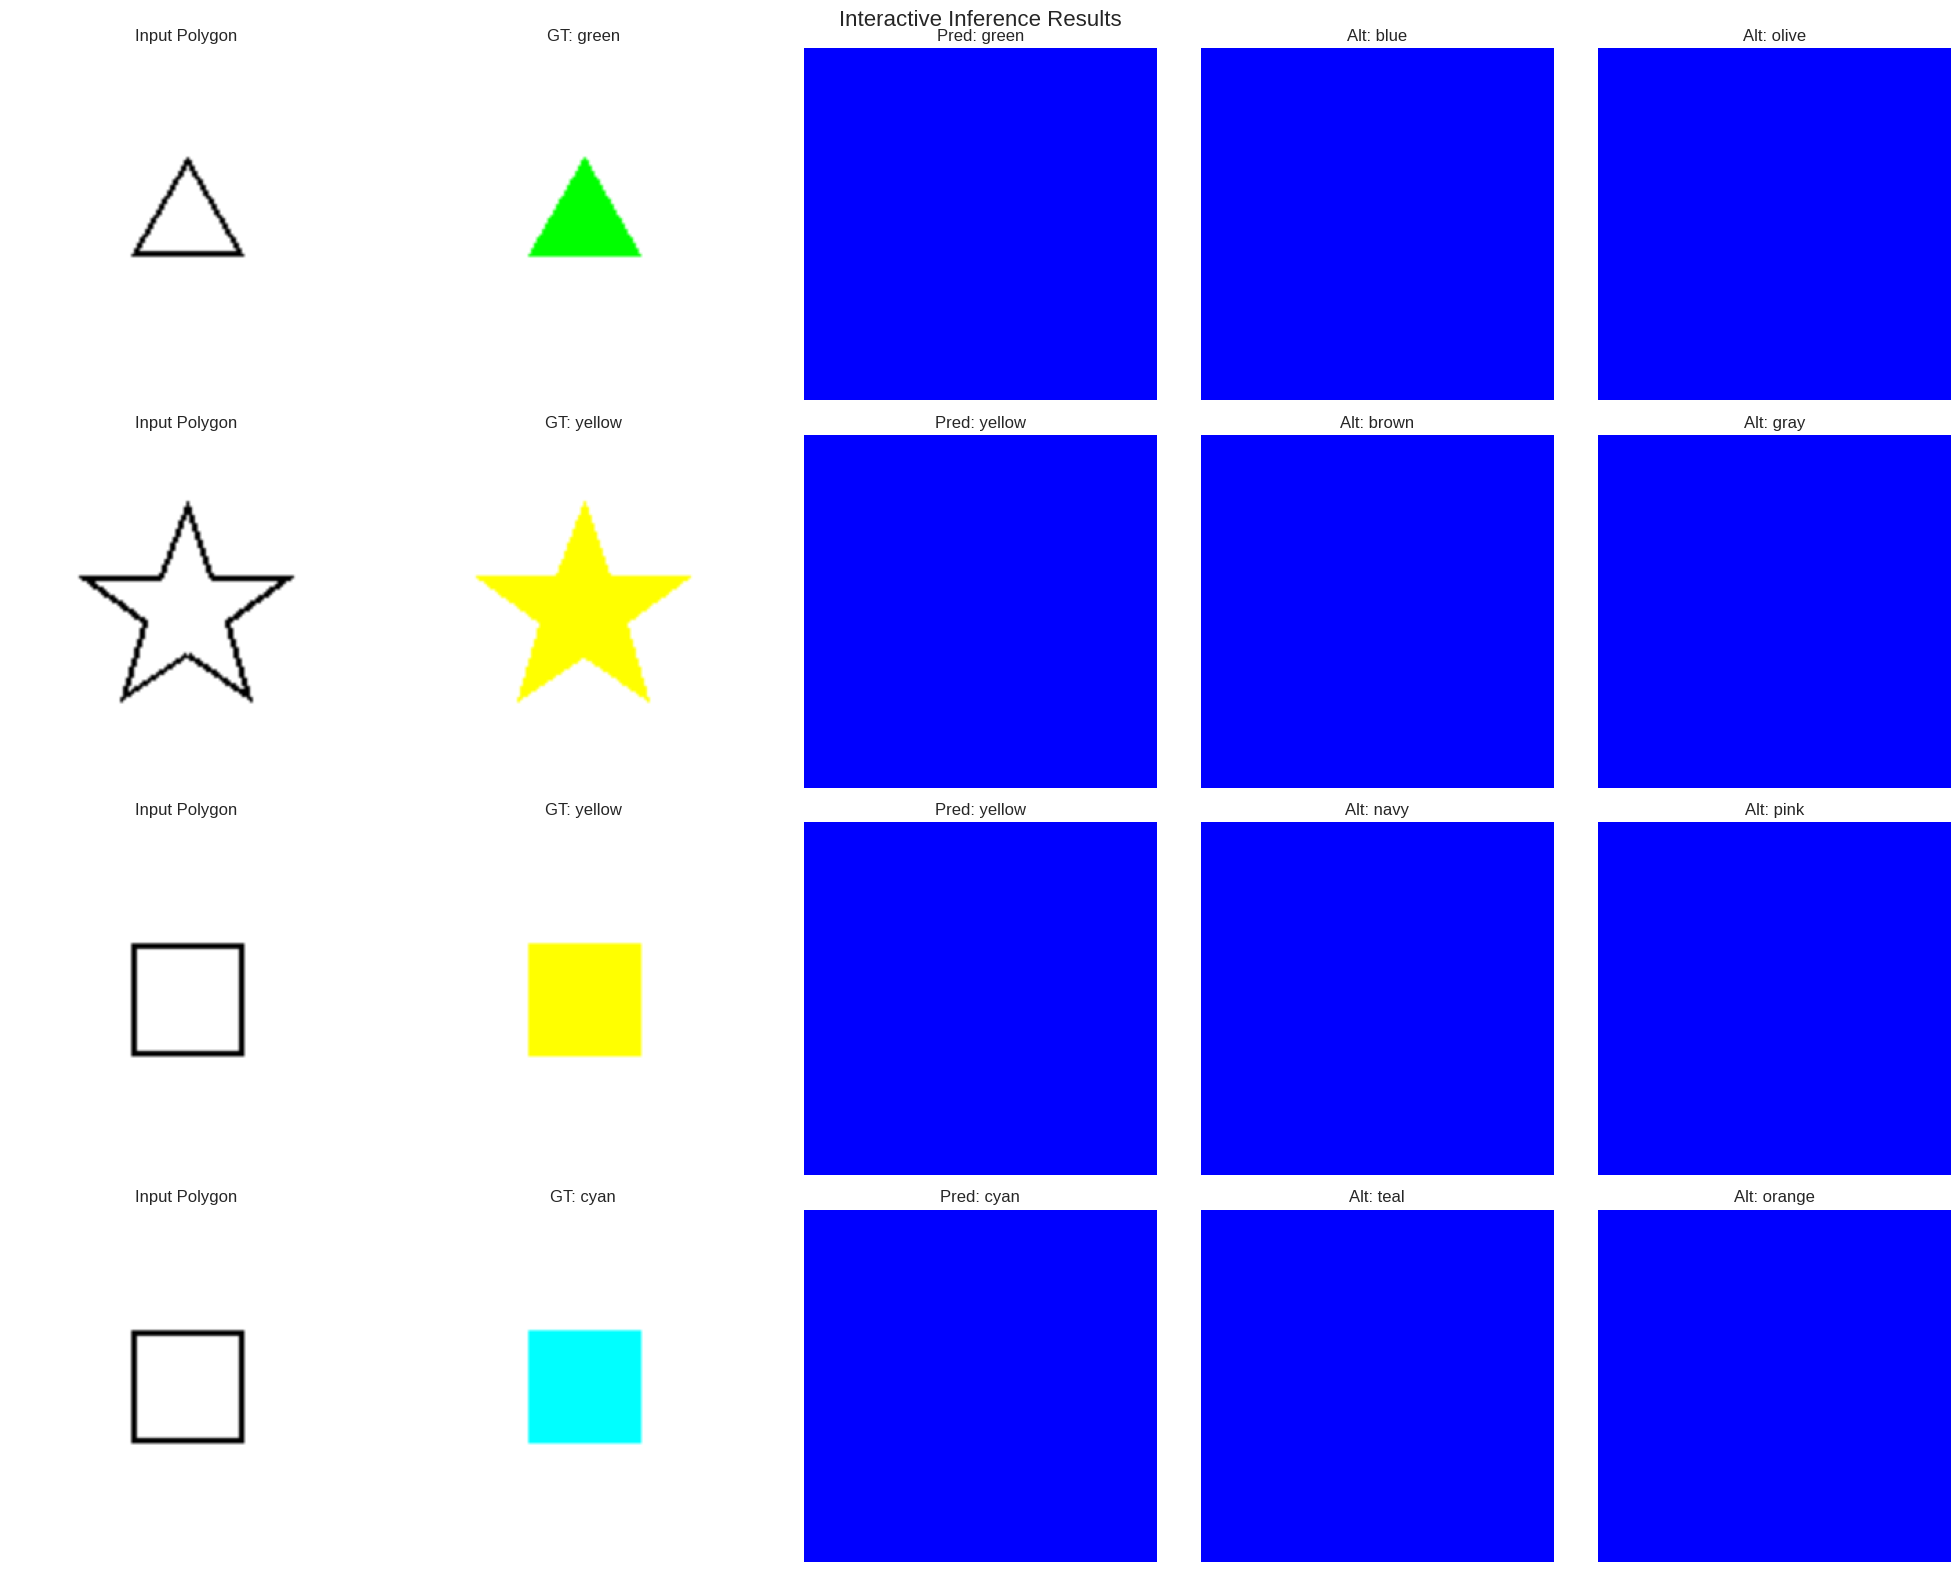

\n3. Color Palette Demonstration:


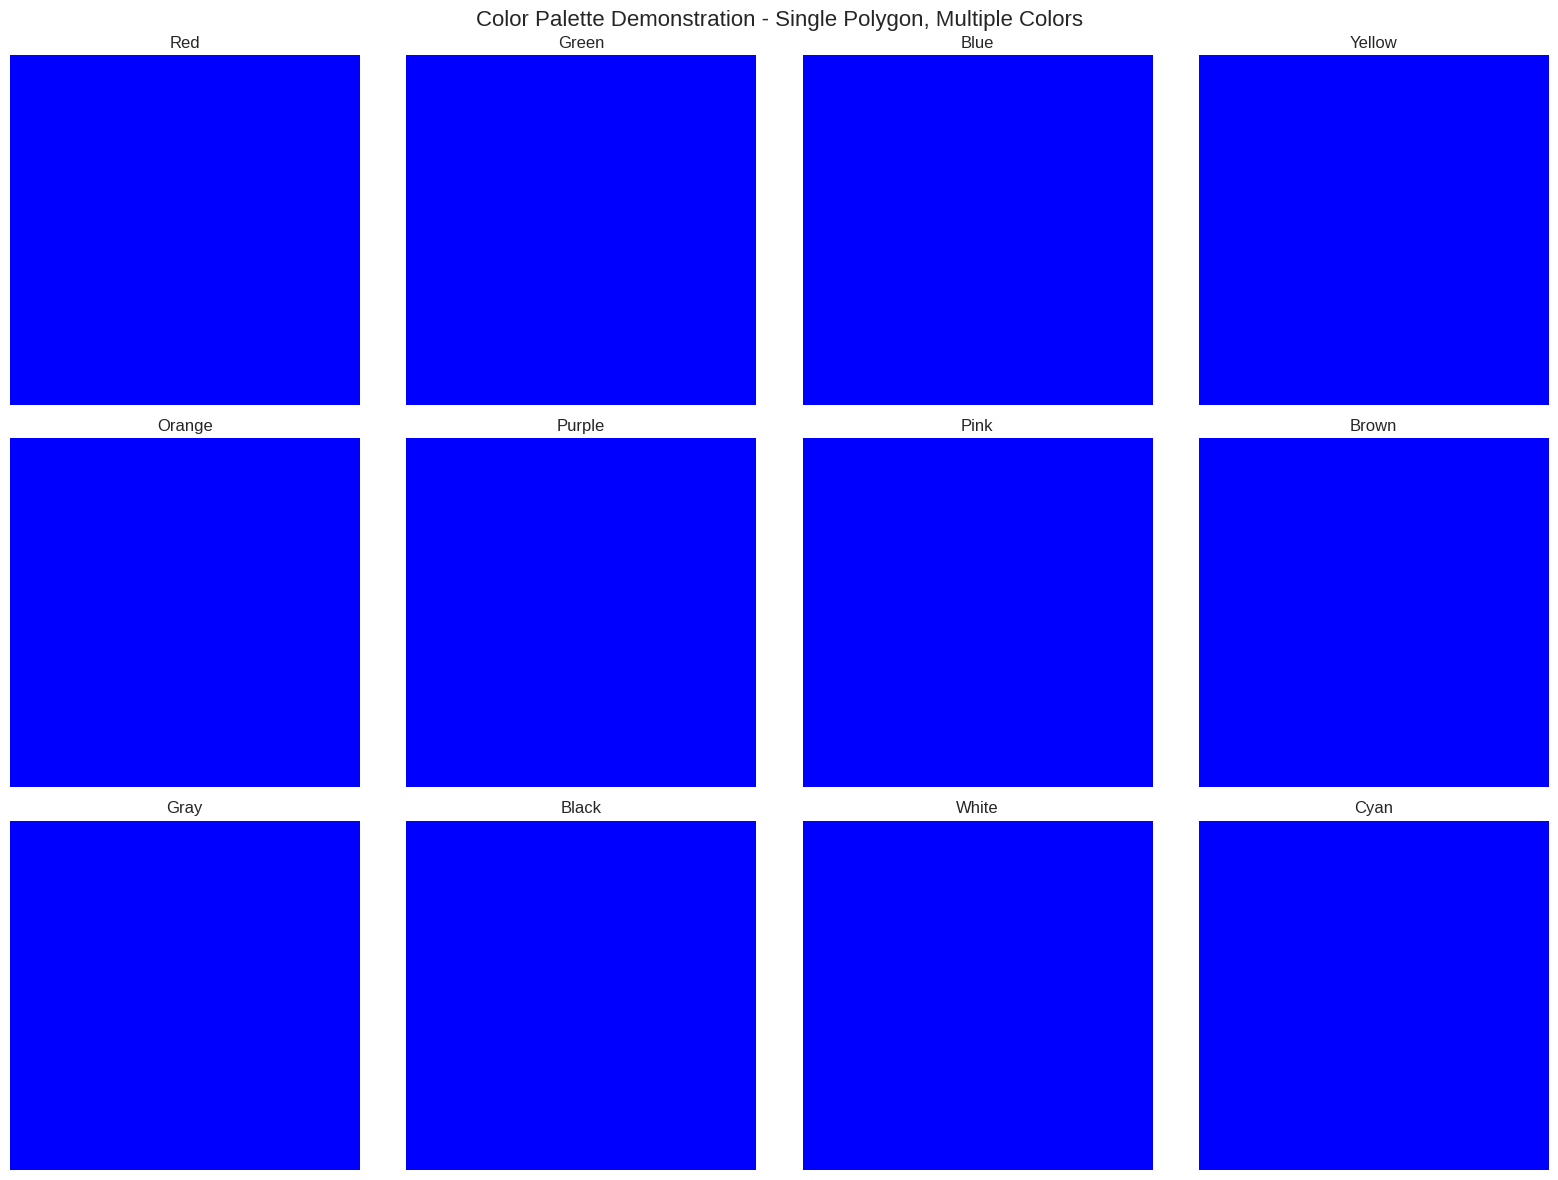

In [13]:
# Inference functions
def inference_single_image(model, image_path, color_name, device, transform=None):
    model.eval()

    # Load and preprocess image
    if isinstance(image_path, str):
        input_image = Image.open(image_path).convert('RGB')
    else:
        input_image = image_path

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    # Preprocess input
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Get color index
    color_idx = color_to_idx.get(color_name, 0)
    color_tensor = torch.tensor([color_idx]).to(device)

    # Generate prediction
    with torch.no_grad():
        output = model(input_tensor, color_tensor)

    # Denormalize output
    output_denorm = (output.squeeze(0) * 0.5 + 0.5).clamp(0, 1)
    output_image = transforms.ToPILImage()(output_denorm.cpu())

    return output_image

def batch_inference(model, image_paths, colors, device):
    model.eval()

    results = []

    for img_path, color in tqdm(zip(image_paths, colors), total=len(image_paths), desc="Batch Inference"):
        try:
            output_img = inference_single_image(model, img_path, color, device)
            results.append(output_img)
        except Exception as e:
            print(f"Error processing {img_path} with color {color}: {e}")
            results.append(None)

    return results

def interactive_inference(model, dataset, device, num_examples=6):
    """
    Interactive inference with visualization
    """
    model.eval()

    # Select random samples
    indices = random.sample(range(len(dataset)), num_examples)

    fig, axes = plt.subplots(num_examples, 5, figsize=(20, 4*num_examples))
    fig.suptitle('Interactive Inference Results', fontsize=16)

    def denormalize(tensor):
        return (tensor * 0.5 + 0.5).clamp(0, 1)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]

            # Original prediction
            input_img = sample['input'].unsqueeze(0).to(device)
            original_color_idx = torch.tensor([sample['color_idx']]).to(device)
            original_pred = model(input_img, original_color_idx).squeeze(0).cpu()

            # Try different colors
            alternative_colors = random.sample(list(color_to_idx.keys()), 2)
            alt_preds = []

            for alt_color in alternative_colors:
                alt_color_idx = torch.tensor([color_to_idx[alt_color]]).to(device)
                alt_pred = model(input_img, alt_color_idx).squeeze(0).cpu()
                alt_preds.append((alt_color, alt_pred))

            # Visualize
            input_vis = denormalize(sample['input']).permute(1, 2, 0).numpy()
            target_vis = denormalize(sample['target']).permute(1, 2, 0).numpy()
            orig_pred_vis = denormalize(original_pred).permute(1, 2, 0).numpy()

            # Input
            axes[i, 0].imshow(input_vis)
            axes[i, 0].set_title("Input Polygon")
            axes[i, 0].axis('off')

            # Ground truth
            axes[i, 1].imshow(target_vis)
            axes[i, 1].set_title(f"GT: {sample['color_name']}")
            axes[i, 1].axis('off')

            # Original prediction
            axes[i, 2].imshow(orig_pred_vis)
            axes[i, 2].set_title(f"Pred: {sample['color_name']}")
            axes[i, 2].axis('off')

            # Alternative predictions
            for j, (alt_color, alt_pred) in enumerate(alt_preds):
                alt_pred_vis = denormalize(alt_pred).permute(1, 2, 0).numpy()
                axes[i, 3+j].imshow(alt_pred_vis)
                axes[i, 3+j].set_title(f"Alt: {alt_color}")
                axes[i, 3+j].axis('off')

    plt.tight_layout()
    return fig

# Demonstrate inference capabilities
print("=" * 60)
print("INFERENCE DEMONSTRATION")
print("=" * 60)

# 1. Single image inference
print("\\n1. Single Image Inference:")
if len(val_dataset) > 0:
    # Get a sample from validation set
    sample_data = val_dataset[0]

    # Convert tensor back to PIL for demonstration
    sample_input = (sample_data['input'] * 0.5 + 0.5).clamp(0, 1)
    sample_pil = transforms.ToPILImage()(sample_input)

    # Test with original color
    original_color = sample_data['color_name']
    result_original = inference_single_image(model, sample_pil, original_color, device)

    # Test with different color
    different_color = random.choice([c for c in color_to_idx.keys() if c != original_color])
    result_different = inference_single_image(model, sample_pil, different_color, device)

    # Visualize results
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(sample_pil)
    axes[0].set_title("Input Polygon")
    axes[0].axis('off')

    target_vis = (sample_data['target'] * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()
    axes[1].imshow(target_vis)
    axes[1].set_title(f"Ground Truth\\n({original_color})")
    axes[1].axis('off')

    axes[2].imshow(result_original)
    axes[2].set_title(f"Predicted\\n({original_color})")
    axes[2].axis('off')

    axes[3].imshow(result_different)
    axes[3].set_title(f"Different Color\\n({different_color})")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# 2. Interactive inference with multiple colors
print("\\n2. Interactive Inference with Multiple Colors:")
interactive_fig = interactive_inference(model, val_dataset, device, num_examples=4)
plt.show()

# 3. Create a color palette demonstration
def create_color_palette_demo(model, dataset, device):
    """
    Demonstrate the model's ability to generate all colors for a single polygon
    """
    model.eval()

    # Pick a sample polygon
    sample = dataset[0]
    input_img = sample['input'].unsqueeze(0).to(device)

    # Generate for all available colors
    colors_to_test = list(color_to_idx.keys())[:12]  # Test first 12 colors
    cols = 4
    rows = (len(colors_to_test) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    fig.suptitle('Color Palette Demonstration - Single Polygon, Multiple Colors', fontsize=16)

    if rows == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i, color in enumerate(colors_to_test):
            row, col = i // cols, i % cols

            color_idx = torch.tensor([color_to_idx[color]]).to(device)
            pred = model(input_img, color_idx).squeeze(0).cpu()
            pred_vis = (pred * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()

            axes[row, col].imshow(pred_vis)
            axes[row, col].set_title(color.capitalize())
            axes[row, col].axis('off')

    # Hide unused subplots
    for i in range(len(colors_to_test), rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    return fig

print("\\n3. Color Palette Demonstration:")
palette_fig = create_color_palette_demo(model, val_dataset, device)
plt.show()

In [15]:
# Model saving and loading utilities

def save_complete_model(model, save_path='./final_model.pth', config=None, metadata=None):
    os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)

    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_class': 'UNet',
        'model_config': {
            'n_channels': 3,
            'n_classes': 3,
            'num_colors': len(color_to_idx),
            'bilinear': True
        },
        'color_mappings': {
            'color_to_idx': color_to_idx,
            'idx_to_color': idx_to_color,
            'colors': colors
        },
        'training_config': config,
        'metadata': metadata or {},
        'save_timestamp': str(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'),
        'pytorch_version': torch.__version__
    }

    torch.save(save_dict, save_path)
    print(f"Complete model saved to {save_path}")

    # Also save color mappings separately for easy access
    color_mappings_path = save_path.replace('.pth', '_color_mappings.json')
    with open(color_mappings_path, 'w') as f:
        json.dump(save_dict['color_mappings'], f, indent=2)

    print(f"Color mappings saved to {color_mappings_path}")

def load_complete_model(load_path='./final_model.pth', device='cpu'):
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Model file not found: {load_path}")

    print(f"Loading model from {load_path}")
    checkpoint = torch.load(load_path, map_location=device)

    # Recreate model with saved configuration
    model_config = checkpoint['model_config']
    model = UNet(
        n_channels=model_config['n_channels'],
        n_classes=model_config['n_classes'],
        num_colors=model_config['num_colors'],
        bilinear=model_config['bilinear']
    )

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Extract color mappings
    color_mappings = checkpoint['color_mappings']

    # Extract metadata
    metadata = checkpoint.get('metadata', {})
    training_config = checkpoint.get('training_config', {})

    print(f"Model loaded successfully!")
    print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Supports {model_config['num_colors']} colors")

    return model, color_mappings, metadata, training_config

def create_deployment_package(model, save_dir='./deployment_package'):
    """
    Create a complete deployment package with model, utilities, and examples
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save the complete model
    model_path = os.path.join(save_dir, 'unet_polygon_model.pth')
    save_complete_model(model, model_path, config, metadata={'deployment': True})



    # Save inference script
    with open(os.path.join(save_dir, 'inference.py'), 'w') as f:
        f.write(inference_script)
# Save the current model
print("Saving complete model...")
save_complete_model(model, './final_model.pth', config, metadata={
    'model_type': 'UNet for Colored Polygon Generation',
    'training_completed': False,  # Set to True after training
    'best_validation_loss': None,  # Update with actual value after training
    'total_parameters': sum(p.numel() for p in model.parameters())
})


Saving complete model...
Complete model saved to ./final_model.pth
Color mappings saved to ./final_model_color_mappings.json
